# Xây Dựng mô hình

## Các thư viện cần dùng

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import datetime as dt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import (LinearRegression,
                                  Ridge,
                                  Lasso,
                                  HuberRegressor)
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

pd.pandas.set_option('display.max_columns', None)
# pd.pandas.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (20, 8)
plt.style.use('ggplot')

## Đọc dữ liệu

Vì để tăng độ chính xác của mô hình, nhóm em đã thu thập thêm dữ liệu ở Việt Nam đến ngày 24 tháng 5 năm 2023

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/manh0387/BTL_LapTrinhAI/main/dataset/vietnam-covid-data-2405.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,VNM,Asia,Vietnam,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,308.127,32.6,7.15,4.718,6171.884,2.0,245.465,6.0,1.0,45.9,85.847,2.6,75.4,0.704,98186856.0,NaN,NaN,NaN,NaN
1,VNM,Asia,Vietnam,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,308.127,32.6,7.15,4.718,6171.884,2.0,245.465,6.0,1.0,45.9,85.847,2.6,75.4,0.704,98186856.0,NaN,NaN,NaN,NaN
2,VNM,Asia,Vietnam,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,308.127,32.6,7.15,4.718,6171.884,2.0,245.465,6.0,1.0,45.9,85.847,2.6,75.4,0.704,98186856.0,NaN,NaN,NaN,NaN
3,VNM,Asia,Vietnam,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,308.127,32.6,7.15,4.718,6171.884,2.0,245.465,6.0,1.0,45.9,85.847,2.6,75.4,0.704,98186856.0,NaN,NaN,NaN,NaN
4,VNM,Asia,Vietnam,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,308.127,32.6,7.15,4.718,6171.884,2.0,245.465,6.0,1.0,45.9,85.847,2.6,75.4,0.704,98186856.0,NaN,NaN,NaN,NaN


Lấy ra hai cột cần sử dụng

In [3]:
data = df[['date', 'new_cases']]

In [4]:
data.head()

,date,new_cases
0,2020-01-03,0.0
1,2020-01-04,0.0
2,2020-01-05,0.0
3,2020-01-06,0.0
4,2020-01-07,0.0


In [5]:
def getDataByYear(df, year=2020):
    start_date = str(year)
    end_date = str(year) + '-12-31'
    data = df[df['date'].between(start_date, end_date)]
    
    return data

def plot_kde_box(df, year=None, bw_adjust=1, cols='new_cases', title=None):
    fig, axs = plt.subplots(1, 2)
    
    sns.kdeplot(
        data=df,
        x=cols,
        bw_adjust=bw_adjust,
        ax=axs[0]
    )
    sns.boxplot(
        data=df,
        x=cols,
        ax=axs[1]
    )
    axs[0].set_title('KDE')
    axs[1].set_title('Box plot')
    if title:
        plt.suptitle(title, fontsize=20, weight='bold')
    plt.tight_layout()
    plt.show()
    

In [6]:
data['date'] = pd.to_datetime(data['date'])

In [7]:
data_2021 = getDataByYear(data, 2021)
data_2022 = getDataByYear(data, 2022)

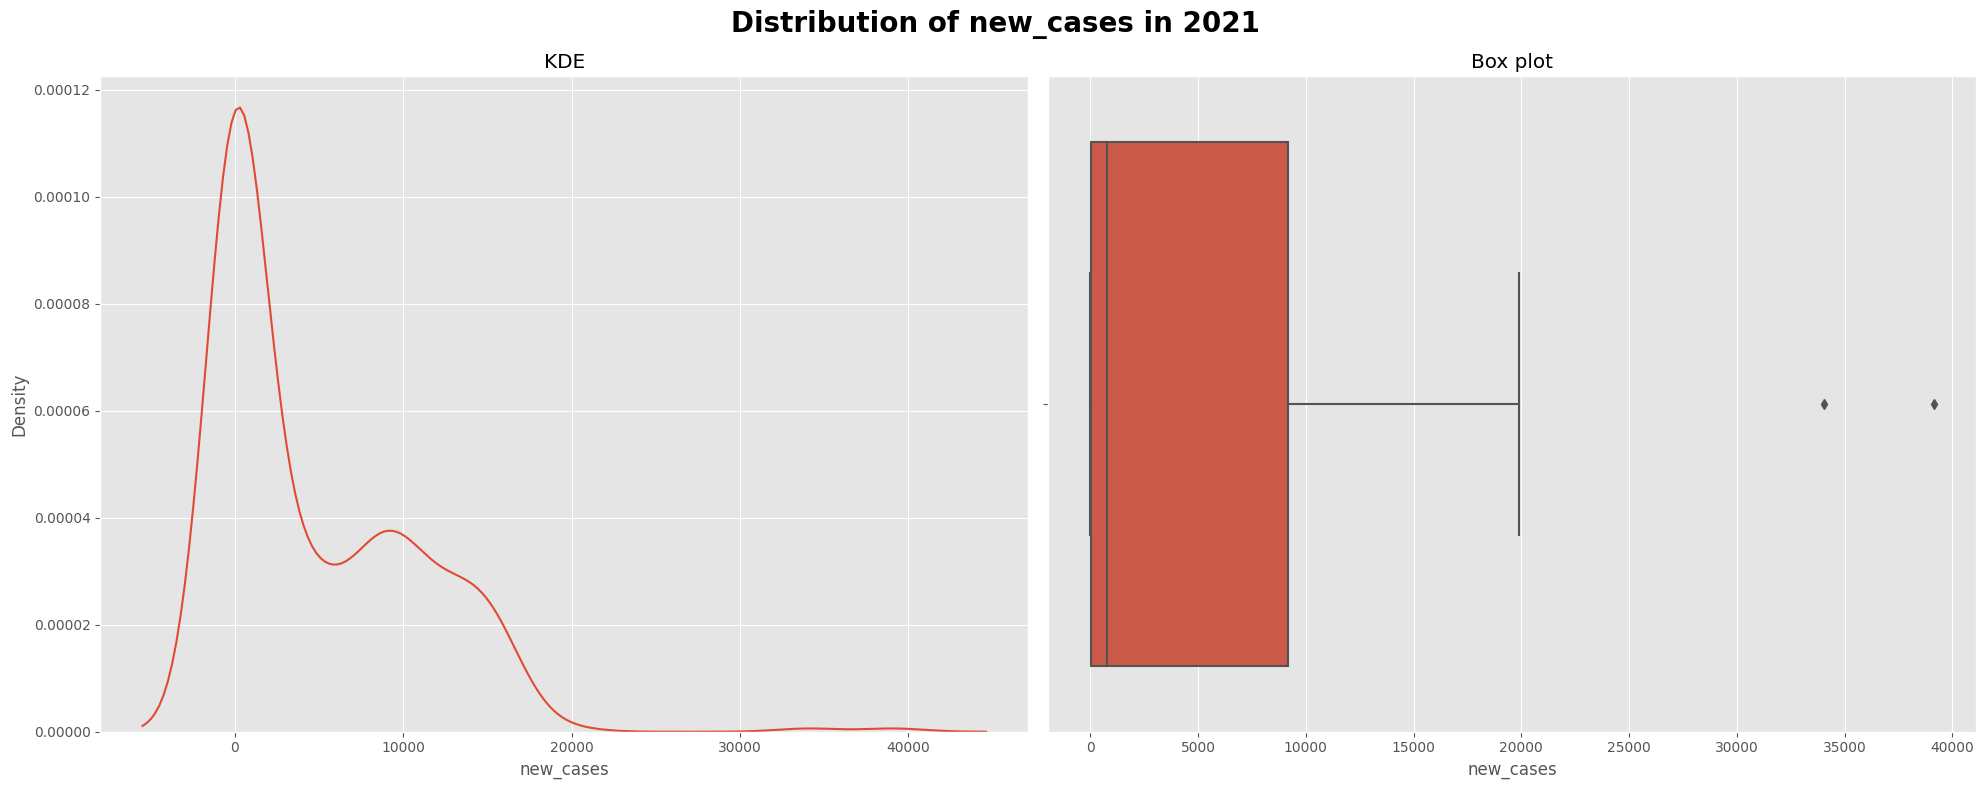

In [8]:
plot_kde_box(data_2021, 2021, title='Distribution of new_cases in 2021')

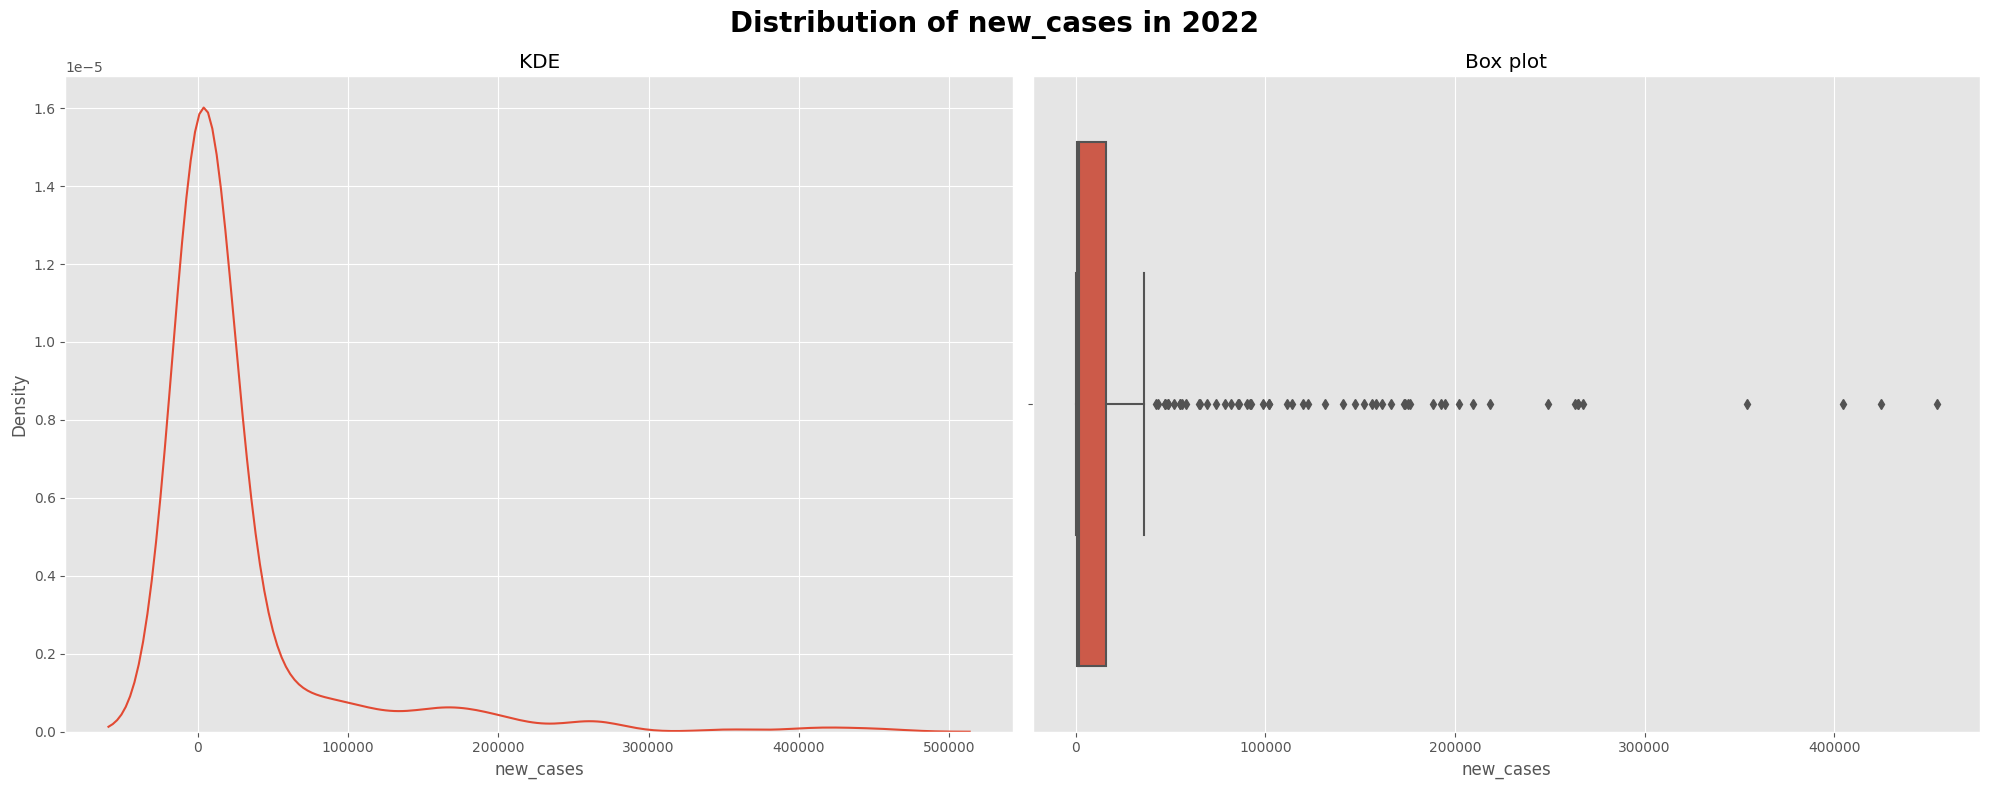

In [9]:
plot_kde_box(data_2022, 2022, title='Distribution of new_cases in 2022')

> Sau khi trực quan hóa dữ liệu, trên từng năm thì thấy rằng năm 2022 có rất nhiều các điểm ngoại lai và điều này là **không tốt** khi xây dựng model, vậy chúng ta cần xử lý các điểm ngoại lai này

## Chuẩn hóa dữ liệu

Để làm giảm bớt sự ảnh hưởng của điểm ngoại lai thì chúng ta cần xử lý với các điểm này bằng **Yeo-Johnson** transform

In [10]:
def transform(data, method = 'yeo-johnson', standardize=True, pt=None):
    if pt == None:
        pt = PowerTransformer(method=method, standardize=standardize)
    else:
        pt = pt
    df = pd.DataFrame()
    new_cases = data['new_cases']
    trans_df = pd.DataFrame(pt.fit_transform(new_cases.values.reshape(-1, 1)))
    trans_df.columns = ['new_cases_trans']
    df['new_cases'] = new_cases
    df.reset_index(inplace=True)
    df['new_cases_trans'] = trans_df['new_cases_trans']
    # del df['index']
    return df, pt

In [11]:
df_2021, _ = transform(data_2021)

In [12]:
df_2021.head()

,index,new_cases,new_cases_trans
0,364,18.0,-1.009989
1,365,8.0,-1.181235
2,366,12.0,-1.098481
3,367,3.0,-1.353818
4,368,7.0,-1.207136


In [13]:
df_2022, _ = transform(data_2022)
df_2022.head()

,index,new_cases,new_cases_trans
0,729,14835.0,0.655282
1,730,16948.0,0.714195
2,731,15936.0,0.686889
3,732,21728.0,0.825552
4,733,17017.0,0.716001


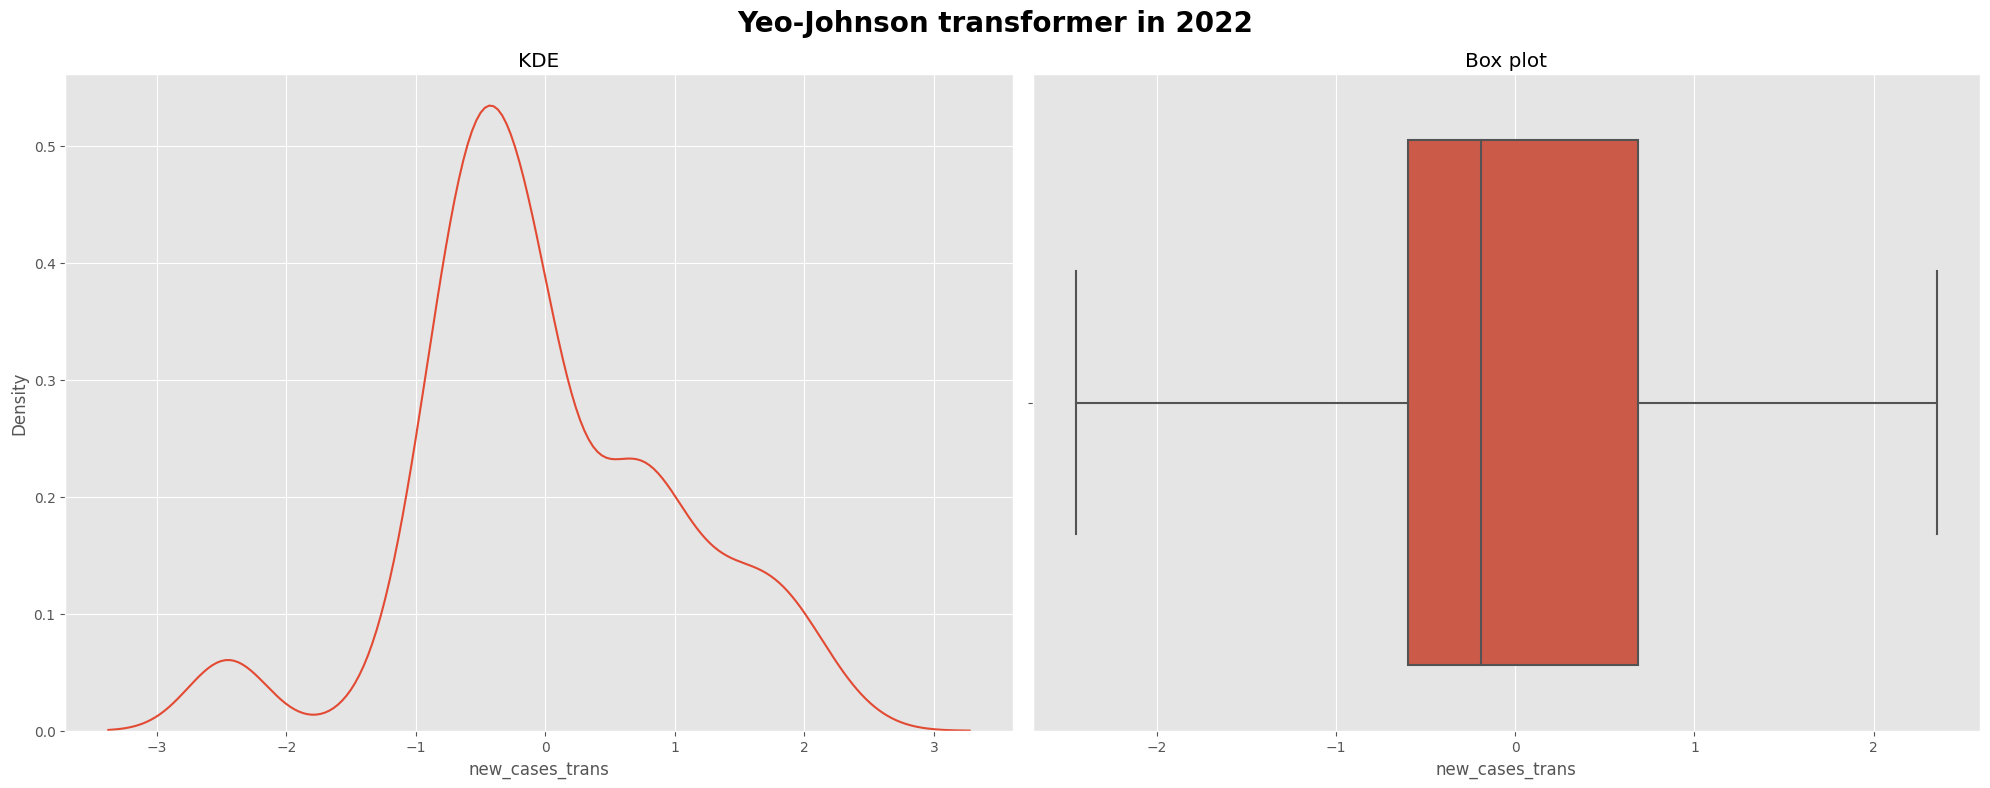

In [14]:
plot_kde_box(df_2022, year=2022, cols='new_cases_trans', title='Yeo-Johnson transformer in 2022')

> Sử dụng Yeo-Johnson ngoài việc giúp cho dữ liệu ít điểm ngoại lai hơn thì cũng làm cho dữ liệu về dạng phân phối chuẩn

## Chuyển dữ liệu chuỗi thời gian sang dữ liệu học có giám sát

In [15]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'],
                        index=idx)
    return pd.concat([df_y, df_xs], axis=1).dropna()

In [16]:
def draw_true_predict(y_true, y_pred):
    size = len(y_true)
    plt.plot(list(range(size)), y_true, label='real', color='blue')
    plt.plot(list(range(size)), y_pred, label='predicted', color='red')
    plt.legend(loc='best')
    plt.title('Real vs Predicted values')
    plt.show()

def calculate_metrics(y_true, y_pred):
    # Calculate metrics
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    print(f"RMSE: {RMSE}, MAPE: {MAPE}, R2: {R2}")

In [17]:
data_2023 = getDataByYear(data, year=2023)

In [18]:
data_2023.head()

,date,new_cases
1094,2023-01-01,0.0
1095,2023-01-02,105.0
1096,2023-01-03,72.0
1097,2023-01-04,83.0
1098,2023-01-05,80.0


In [19]:
df_ready = pd.concat([data_2022, data_2023])

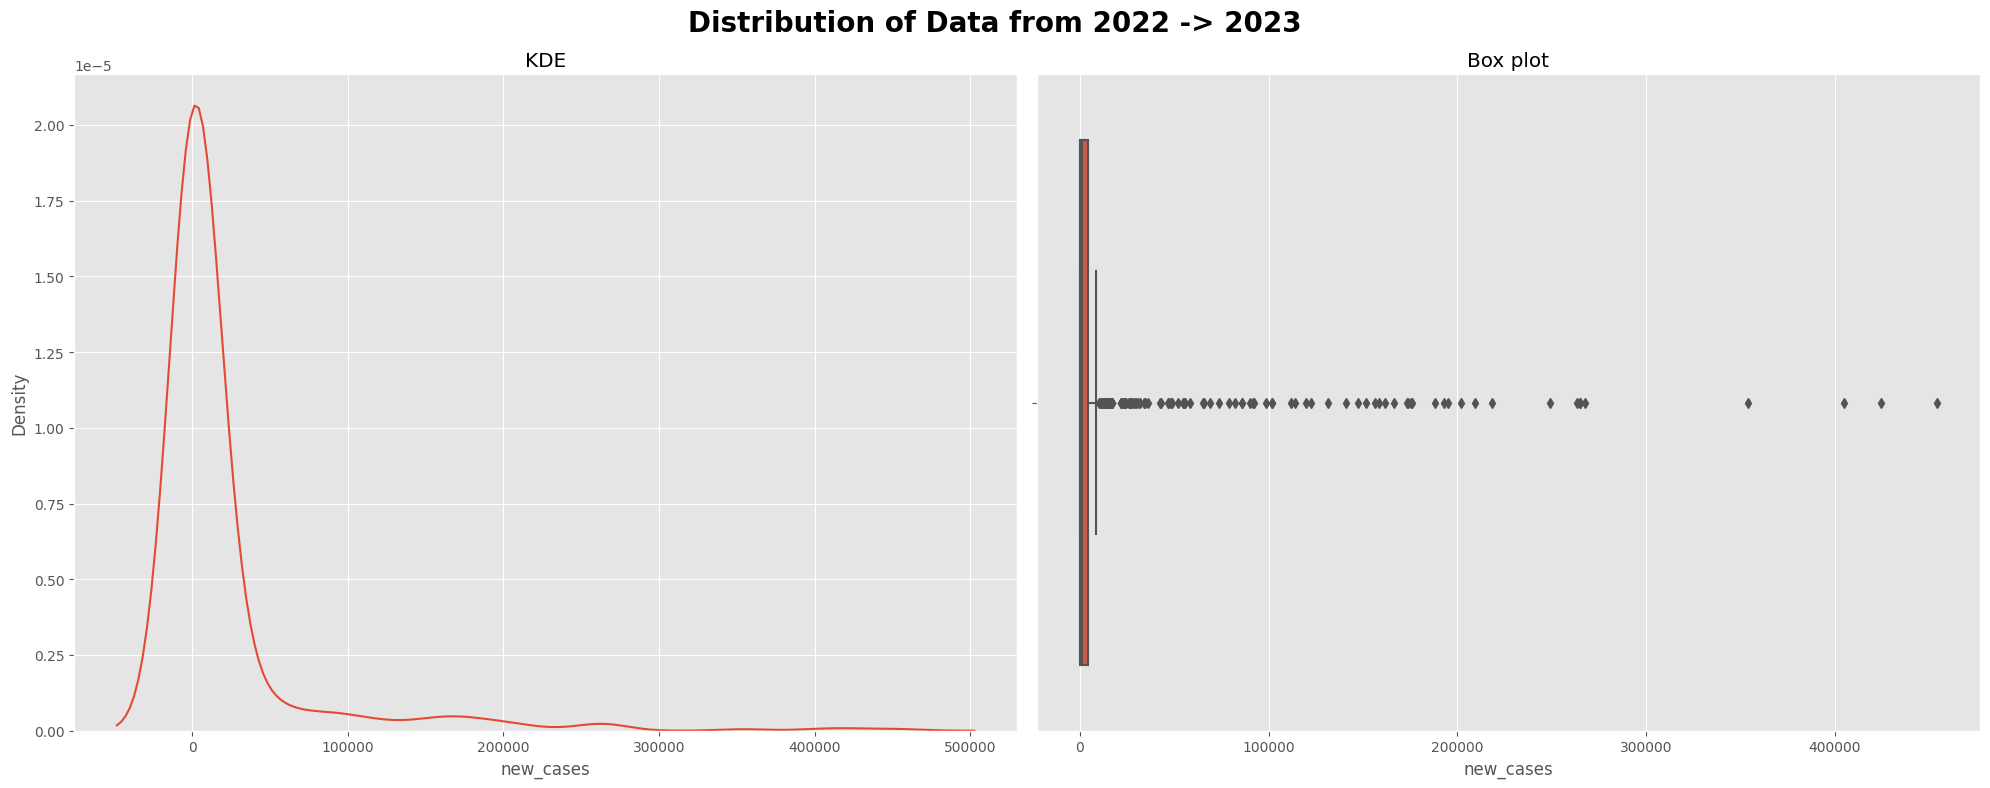

In [20]:
plot_kde_box(df_ready, title='Distribution of Data from 2022 -> 2023')

In [21]:
df_ready.set_index('date', inplace=True)
df_ready.head()

,new_cases
date,
2022-01-01,14835.0
2022-01-02,16948.0
2022-01-03,15936.0
2022-01-04,21728.0
2022-01-05,17017.0


In [22]:
df_ready.dropna(inplace=True)

In [23]:
df_ready

,new_cases
date,
2022-01-01,14835.0
2022-01-02,16948.0
2022-01-03,15936.0
2022-01-04,21728.0
2022-01-05,17017.0
...,...
2023-05-18,2043.0
2023-05-19,1927.0
2023-05-20,1980.0


In [24]:
data_2021.set_index('date', inplace=True)

In [25]:
df_ready = pd.concat([data_2021, df_ready])

In [26]:
df_ready_os = one_step_forecast(df_ready, 15)

## Xây dựng mô hình học máy

In [27]:
X, y = df_ready_os.iloc[:, 1:], df_ready_os['y']

In [28]:
pt_feature = PowerTransformer(method='yeo-johnson', standardize=True)
pt_label = PowerTransformer(method='yeo-johnson', standardize=True)

### Chia dữ liệu

In [29]:
X_train, X_test = X[X.index <= '2022-12-31'], X[X.index >= '2023-01-01']
y_train, y_test = y[y.index <= '2022-12-31'], y[y.index >= '2023-01-01']

### Chuẩn hóa dữ liệu

In [30]:
X_train, X_test = X_train.values, X_test.values
y_train = np.reshape(y_train.values, (-1, 1))
y_test = np.reshape(y_test.values, (-1, 1))
pt_feature.fit(X_train)
X_train_pts = pt_feature.transform(X_train)
X_test_pts = pt_feature.transform(X_test)

pt_label.fit(y_train)
y_train_pts = pt_label.transform(y_train)

### Mô hình hồi quy tuyến tính

In [31]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train_pts, y_train_pts)

yhat = reg.predict(X_test_pts)

yhat_actual = pt_label.inverse_transform(
    np.reshape(yhat, (-1, 1))
)
calculate_metrics(yhat_actual, y_test)

RMSE: 393.4934883724897, MAPE: 0.7591785705078538, R2: 0.8287773105257582


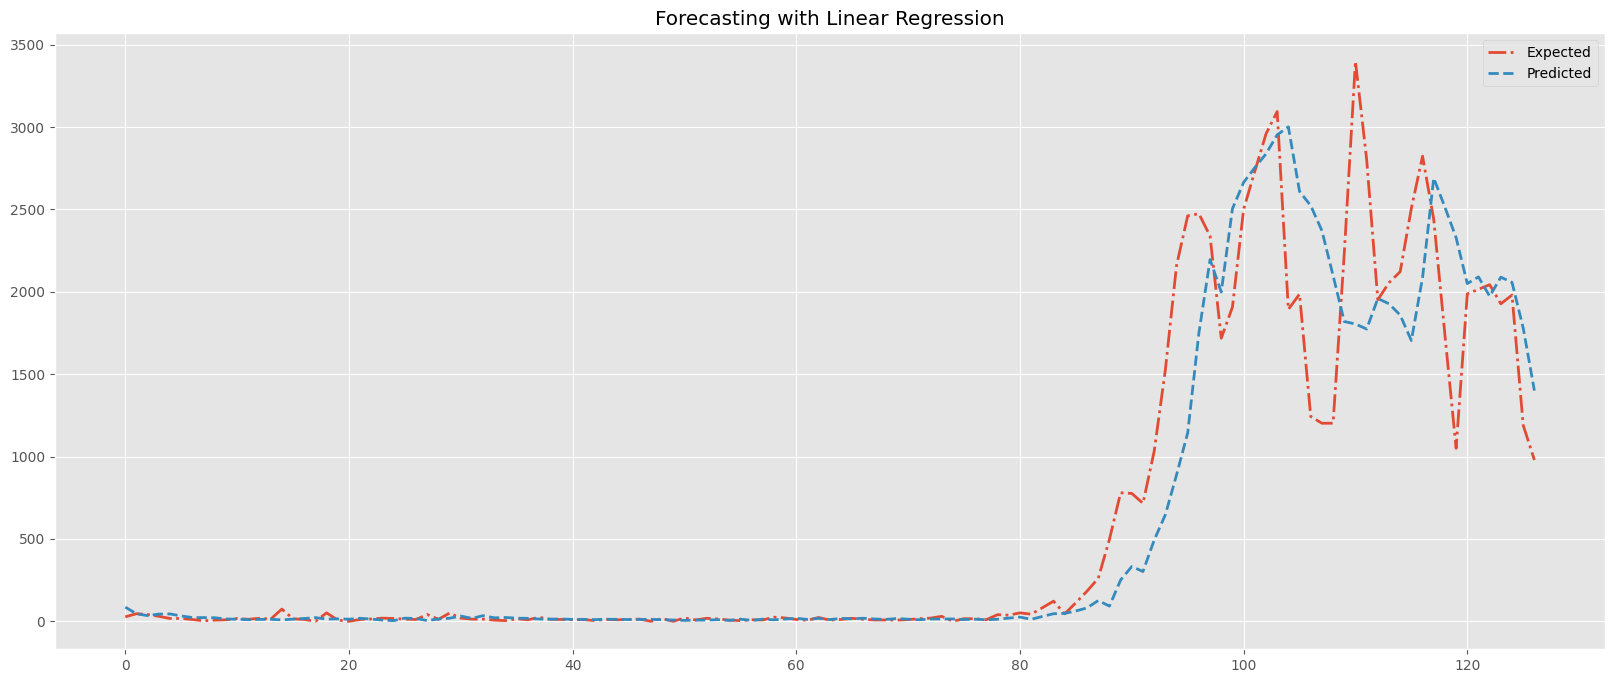

In [32]:
plt.plot(y_test, label='Expected', linewidth=2, linestyle='-.')
plt.plot(yhat_actual, label='Predicted', linewidth=2, linestyle='--')
plt.legend()
plt.title(f'Forecasting with Linear Regression')
plt.show()

### GridSearch CV + Huber Regressor

Fitting 5 folds for each of 231 candidates, totalling 1155 fits
[CV 1/5] END ..........epsilon=1.0, max_iter=50;, score=0.777 total time=   0.0s
[CV 2/5] END ..........epsilon=1.0, max_iter=50;, score=0.956 total time=   0.0s
[CV 3/5] END ..........epsilon=1.0, max_iter=50;, score=0.925 total time=   0.0s
[CV 4/5] END ..........epsilon=1.0, max_iter=50;, score=0.482 total time=   0.0s
[CV 5/5] END ..........epsilon=1.0, max_iter=50;, score=0.280 total time=   0.0s
[CV 1/5] END .........epsilon=1.0, max_iter=150;, score=0.777 total time=   0.1s
[CV 2/5] END .........epsilon=1.0, max_iter=150;, score=0.956 total time=   0.1s
[CV 3/5] END .........epsilon=1.0, max_iter=150;, score=0.925 total time=   0.0s
[CV 4/5] END .........epsilon=1.0, max_iter=150;, score=0.480 total time=   0.0s
[CV 5/5] END .........epsilon=1.0, max_iter=150;, score=0.283 total time=   0.0s
[CV 1/5] END .........epsilon=1.0, max_iter=250;, score=0.776 total time=   0.1s
[CV 2/5] END .........epsilon=1.0, max_iter=2

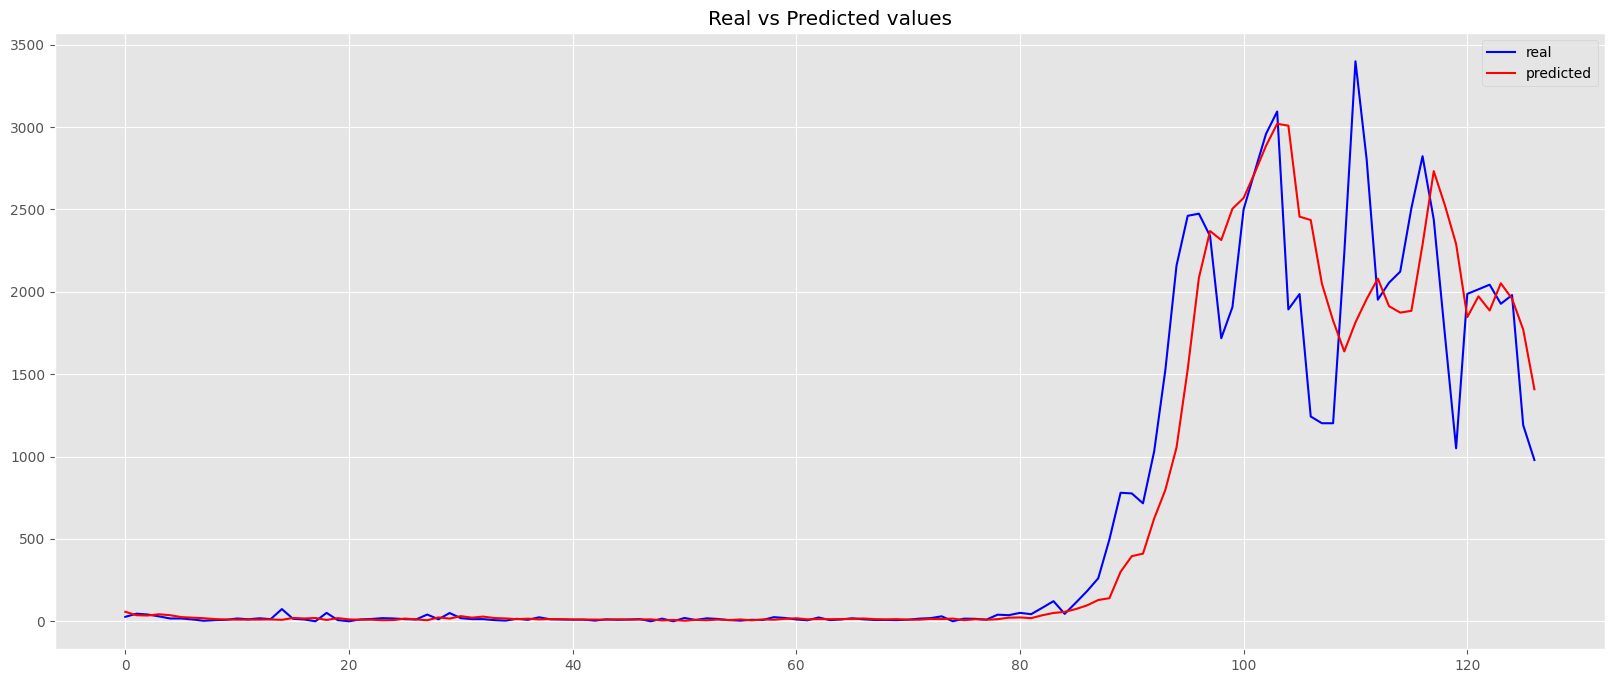

In [33]:
epsilon = np.linspace(1, 2, 21)
max_iter = [x + 50 for x in range(0, 1000, 100)]
max_iter.append(1000)
# max_iter
# epsilon
param_grid = {
    'epsilon': list(epsilon),
    'max_iter': max_iter
}

grid = GridSearchCV(HuberRegressor(fit_intercept=False), param_grid, refit=True, verbose=3)
grid.fit(X_train_pts, y_train_pts)

pred = grid.predict(X_test_pts)

# Calculate metrics
calculate_metrics(y_test, pt_label.inverse_transform(np.reshape(pred, (-1, 1))))

draw_true_predict(y_test, pt_label.inverse_transform(np.reshape(pred, (-1, 1))))

- Như đã nhận xét phía trên, dữ liệu có rất nhiều các điểm ngoại lai, điều này gây bất lợi cho bất kì mô hình nào, dù là mô hình mạnh.
- Vì đến giai đoạn đầu 2023, hầu hết mọi người đã được tiêm vaccine và đã có kháng thể nên đã ít dần những ca mắc Covid, điều này không có nghĩa mọi người đã không bị mắc covid, mà là vì mọi người đã không còn quá lo lắng về căn bệnh này nên không khai báo

## Xây dựng mô hình học sâu

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [35]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

In [36]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.rnn = nn.RNN(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        rnn_o, hn = self.rnn(x, hn)
        rnn_o = self.dropout(rnn_o)
        # reshape
        rnn_o = rnn_o.view(-1, self.hidden_dim)
        output = self.fc(rnn_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

In [37]:
def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    pt = kwargs['trans']
    actual = pt.inverse_transform(
            np.reshape(y_test.detach().numpy().ravel(), (-1, 1))
        )
    pred = pt.inverse_transform(
        np.reshape(y_hat.detach().numpy().ravel(), (-1, 1))
        )
    # print(pred.shape)
    idx = kwargs['idx']
    pd.Series(actual.flatten(), index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred.flatten(), index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history, actual, pred

In [38]:
def split_data(data, split=0.10):
    n = int(len(data) * split)
    train, test = data.iloc[:-n], data.iloc[-n:]
    n = int(len(train) * split)
    train, val = train.iloc[:-n], train.iloc[-n:]
    assert len(test) + len(train) + len(val) == len(data)
    return train, test, val

In [39]:
def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

In [40]:
pt_feature = PowerTransformer(method='yeo-johnson', standardize=True)
pt_label = PowerTransformer(method='yeo-johnson', standardize=True)

In [41]:
df_ready_os_DL = one_step_forecast(df_ready, 30)
df_ready_os_DL.head()

,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,38.0,18.0,8.0,12.0,3.0,7.0,1.0,4.0,3.0,1.0,1.0,1.0,5.0,1.0,10.0,5.0,1.0,0.0,2.0,1.0,4.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,98.0,88.0,42.0
2021-01-02,32.0,8.0,12.0,3.0,7.0,1.0,4.0,3.0,1.0,1.0,1.0,5.0,1.0,10.0,5.0,1.0,0.0,2.0,1.0,4.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,98.0,88.0,42.0,38.0
2021-01-03,40.0,12.0,3.0,7.0,1.0,4.0,3.0,1.0,1.0,1.0,5.0,1.0,10.0,5.0,1.0,0.0,2.0,1.0,4.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,98.0,88.0,42.0,38.0,32.0
2021-01-04,57.0,3.0,7.0,1.0,4.0,3.0,1.0,1.0,1.0,5.0,1.0,10.0,5.0,1.0,0.0,2.0,1.0,4.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,98.0,88.0,42.0,38.0,32.0,40.0
2021-01-05,9.0,7.0,1.0,4.0,3.0,1.0,1.0,1.0,5.0,1.0,10.0,5.0,1.0,0.0,2.0,1.0,4.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,98.0,88.0,42.0,38.0,32.0,40.0,57.0


In [42]:
train_covid, test_covid, val_covid = split_data(df_ready_os_DL, 0.15)

In [43]:
print(f'Train size: {train_covid.shape}')
print(f'Test size: {test_covid.shape}')
print(f'Val size: {val_covid.shape}')

Train size: (609, 31)
Test size: (126, 31)
Val size: (107, 31)


In [44]:
train_covid_x, train_covid_y = train_covid.iloc[:, 1:].values, np.reshape(train_covid['y'].values, (-1, 1))
pt_feature.fit(train_covid_x)
train_covid_x_trans = pt_feature.transform(train_covid_x)
pt_label.fit(train_covid_y)
train_covid_y_trans = pt_label.transform(train_covid_y)
train_covid_trans = pd.concat([pd.DataFrame(train_covid_y_trans), pd.DataFrame(train_covid_x_trans)], axis=1)
train_covid_trans.columns = train_covid.columns
train_covid_trans.index = train_covid.index

In [45]:
train_covid_trans.shape

(609, 31)

In [46]:
test_covid_x, test_covid_y = test_covid.iloc[:, 1:].values, np.reshape(test_covid['y'].values, (-1, 1))
test_covid_x_trans = pt_feature.transform(test_covid_x)
test_covid_y_trans = pt_label.transform(test_covid_y)
test_covid_trans = pd.concat([pd.DataFrame(test_covid_y_trans), pd.DataFrame(test_covid_x_trans)], axis=1)
test_covid_trans.columns = test_covid.columns
test_covid_trans.index = test_covid.index

In [47]:
test_covid_trans.shape

(126, 31)

In [48]:
val_covid_x, val_covid_y = val_covid.iloc[:, 1:].values, np.reshape(val_covid['y'].values, (-1, 1))
val_covid_x_trans = pt_feature.transform(val_covid_x)
val_covid_y_trans = pt_label.transform(val_covid_y)
val_covid_trans = pd.concat([pd.DataFrame(val_covid_y_trans), pd.DataFrame(val_covid_x_trans)], axis=1)
val_covid_trans.columns = val_covid.columns
val_covid_trans.index = val_covid.index

In [49]:
val_covid_trans.shape

(107, 31)

In [50]:
(y_train_covid, 
 y_val_covid, 
 y_test_covid, 
 x_train_covid, 
 x_val_covid, 
 x_test_covid) = features_target_pt(train_covid_trans, 
                               val_covid_trans, 
                               test_covid_trans)

### Model 1:

- `Số lượng layers`: 2
- `Số lượng units trên từng layers`: 30
- `Epochs:` 500
- `Learning rate`: 0.01

0/50 - Loss:  0.8926752209663391, val_loss: 0.32817697525024414
25/50 - Loss:  0.1124492809176445, val_loss: 0.16495223343372345
Test MSE Loss: 0.0383


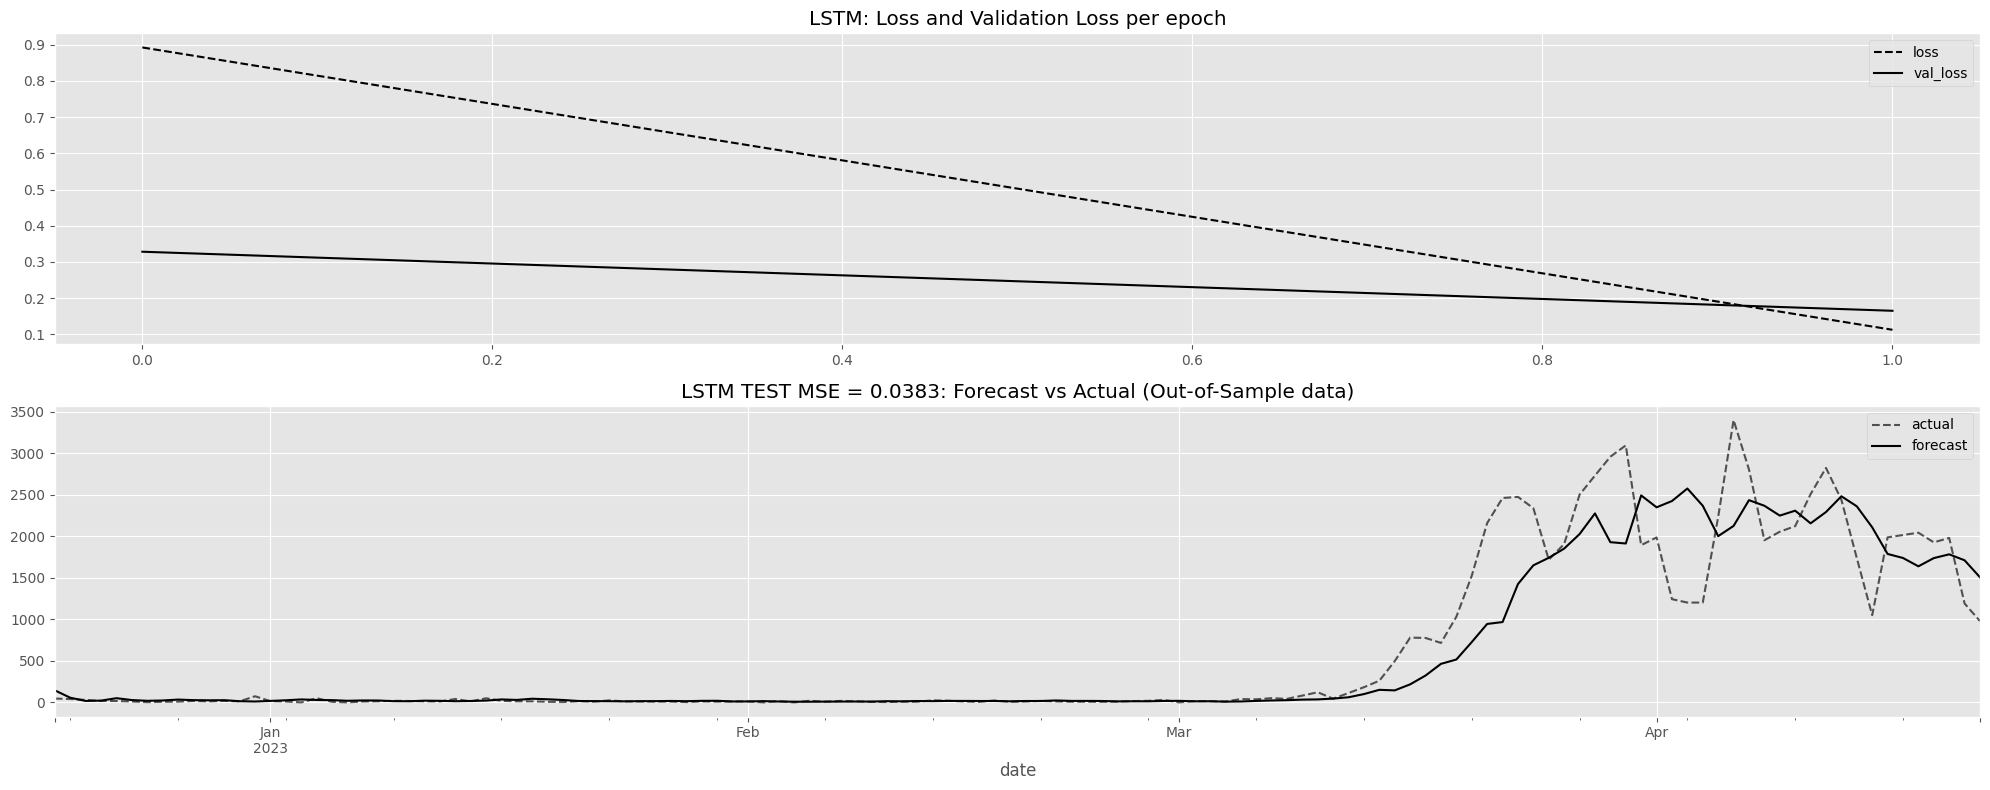

RMSE: 396.89501953125, MAPE: 3516716806045696.0, R2: 0.827925803086488


In [174]:
params_covid_model1 = {'input_size':x_train_covid.shape[1],
'output_size':1,
'units':30,
'n_layers': 1,
'epochs': 50,
'print_every': 25,
'lr': 0.01,
'train_data': (x_train_covid, y_train_covid),
'val_data': (x_val_covid, y_val_covid),
'test_data': (x_test_covid, y_test_covid),
'idx': test_covid.index,
'trans': pt_label}
covid_lstm, history_a_lstm,actual, pred = train_model_pt('LSTM', **params_covid_model1)
calculate_metrics(actual, pred)

### Model 2:

- `Số lượng layers`: 3
- `Số lượng units trên từng layers`: 20
- `Epochs:` 300
- `Learning rate`: 0.01

0/50 - Loss:  1.0899569988250732, val_loss: 0.7677627205848694
25/50 - Loss:  0.23206526041030884, val_loss: 0.13965392112731934
Test MSE Loss: 0.0345


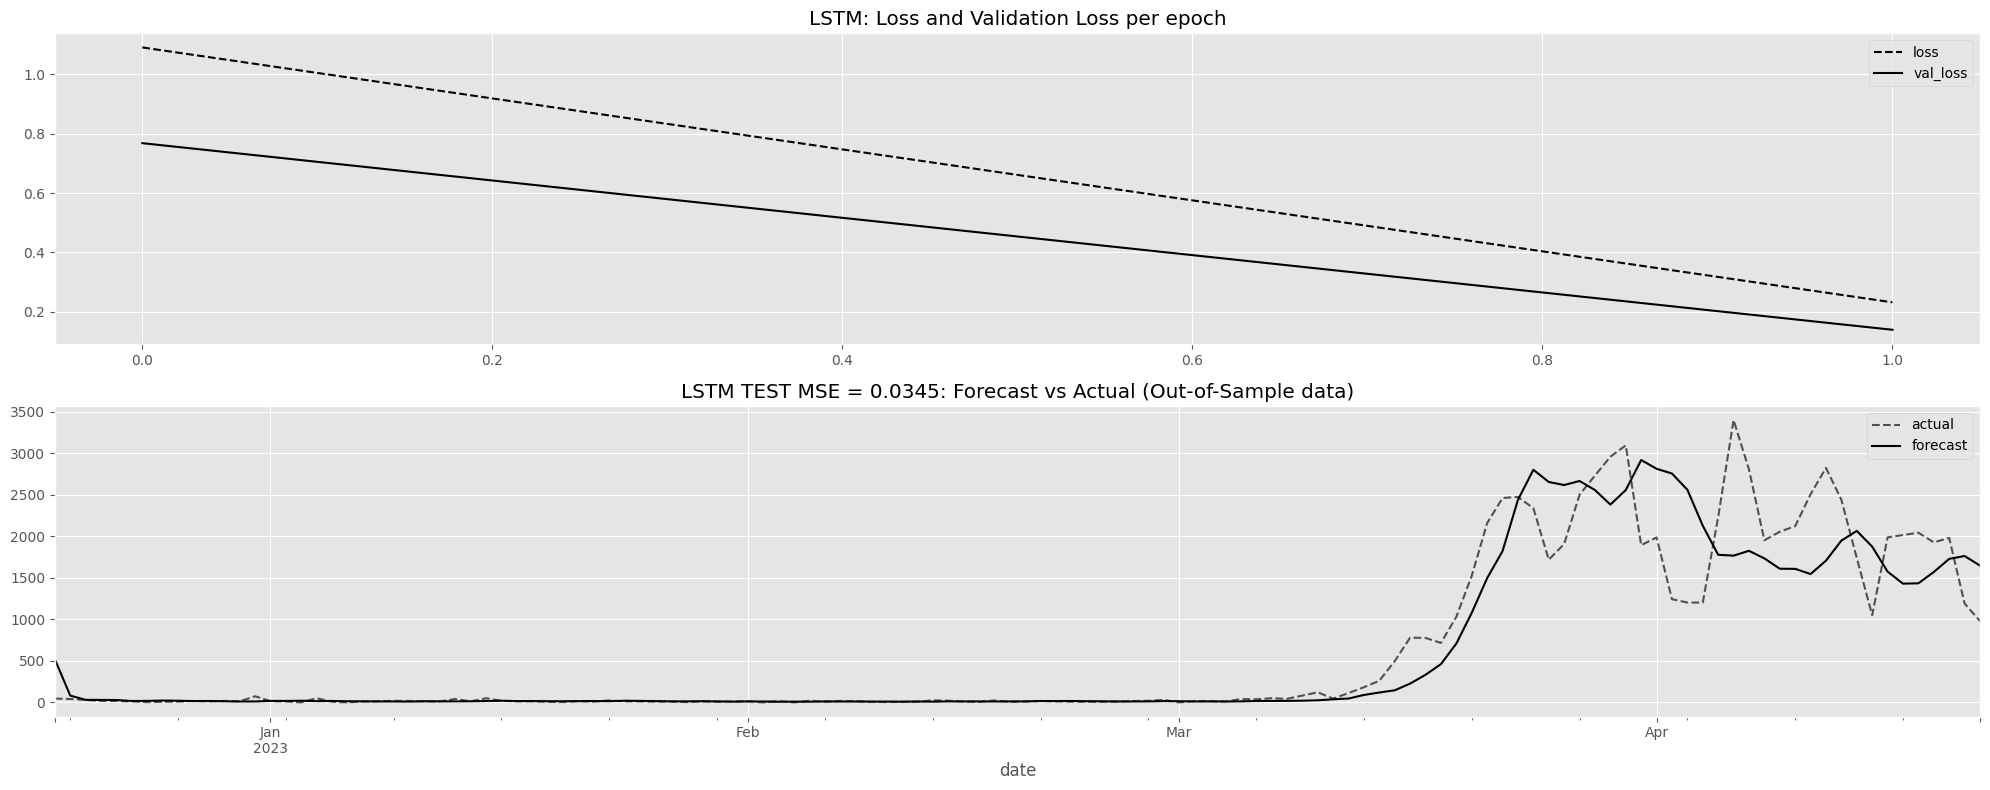

RMSE: 403.48834228515625, MAPE: 2461785328189440.0, R2: 0.8221612426733287


In [173]:
params_covid_model2 = {'input_size':x_train_covid.shape[1],
'output_size':1,
'units':15,
'n_layers': 2,
'epochs': 50,
'print_every': 25,
'lr': 0.01,
'train_data': (x_train_covid, y_train_covid),
'val_data': (x_val_covid, y_val_covid),
'test_data': (x_test_covid, y_test_covid),
'idx': test_covid.index,
'trans': pt_label}
covid_lstm2, history_a_lstm2,actual2, pred2 = train_model_pt('LSTM', **params_covid_model2)
calculate_metrics(actual2, pred2)